In [1]:
import pandas as pd
import numpy as np


from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

<h1><i>Importation du dataset</i></h1>

In [2]:
df_train = pd.read_csv('train_Insurance.csv')
df_test = pd.read_csv('test_Insurance.csv')
df_train

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
0,H13501,2012,1.0,1,N,V,V,U,1240.0,Wood-framed,without,75117,non
1,H14962,2012,1.0,0,N,V,V,U,900.0,Non-combustible,without,62916,non
2,H17755,2013,1.0,1,V,N,O,R,4984.0,Non-combustible,4,31149,oui
3,H13369,2016,0.5,0,N,V,V,U,600.0,Wood-framed,without,6012,oui
4,H12988,2012,1.0,0,N,V,V,U,900.0,Non-combustible,without,57631,non
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5007,H13682,2013,1.0,0,N,V,V,U,550.0,Ordinary,without,33063,oui
5008,H18342,2012,0.5,0,V,N,O,R,1000.0,Fire-resistive,4,13004,non
5009,H16892,2015,1.0,1,V,N,O,R,480.0,Ordinary,3,94059,non
5010,H18805,2012,0.5,0,V,N,O,R,536.0,Fire-resistive,4,74243,non


<h1><i>Changer les valeurs des NumberOfWindows</i></h1>

In [3]:
df_train["NumberOfWindows"] = df_train["NumberOfWindows"].apply(lambda x: 0 if x=='without' else x)
df_train

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
0,H13501,2012,1.0,1,N,V,V,U,1240.0,Wood-framed,0,75117,non
1,H14962,2012,1.0,0,N,V,V,U,900.0,Non-combustible,0,62916,non
2,H17755,2013,1.0,1,V,N,O,R,4984.0,Non-combustible,4,31149,oui
3,H13369,2016,0.5,0,N,V,V,U,600.0,Wood-framed,0,6012,oui
4,H12988,2012,1.0,0,N,V,V,U,900.0,Non-combustible,0,57631,non
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5007,H13682,2013,1.0,0,N,V,V,U,550.0,Ordinary,0,33063,oui
5008,H18342,2012,0.5,0,V,N,O,R,1000.0,Fire-resistive,4,13004,non
5009,H16892,2015,1.0,1,V,N,O,R,480.0,Ordinary,3,94059,non
5010,H18805,2012,0.5,0,V,N,O,R,536.0,Fire-resistive,4,74243,non


In [4]:
df_train.isnull().sum()

Customer Id            0
YearOfObservation      0
Insured_Period         0
Residential            0
Building_Painted       0
Building_Fenced        0
Garden                 4
Settlement             0
Building Dimension    77
Building_Type          0
NumberOfWindows        0
Geo_Code              73
Claim                  0
dtype: int64

<h1><i>Remplir les valeurs nulls</i></h1>

In [5]:
df_train['Garden'].ffill(inplace=True)
df_train['Building Dimension'].ffill(inplace=True)
df_train['Geo_Code'].ffill(inplace=True)
df_train

C:\Users\houss\AppData\Local\Temp\ipykernel_19628\4181755952.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Garden'].ffill(inplace=True)
C:\Users\houss\AppData\Local\Temp\ipykernel_19628\4181755952.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
0,H13501,2012,1.0,1,N,V,V,U,1240.0,Wood-framed,0,75117,non
1,H14962,2012,1.0,0,N,V,V,U,900.0,Non-combustible,0,62916,non
2,H17755,2013,1.0,1,V,N,O,R,4984.0,Non-combustible,4,31149,oui
3,H13369,2016,0.5,0,N,V,V,U,600.0,Wood-framed,0,6012,oui
4,H12988,2012,1.0,0,N,V,V,U,900.0,Non-combustible,0,57631,non
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5007,H13682,2013,1.0,0,N,V,V,U,550.0,Ordinary,0,33063,oui
5008,H18342,2012,0.5,0,V,N,O,R,1000.0,Fire-resistive,4,13004,non
5009,H16892,2015,1.0,1,V,N,O,R,480.0,Ordinary,3,94059,non
5010,H18805,2012,0.5,0,V,N,O,R,536.0,Fire-resistive,4,74243,non


<h1><i>Changer les valeur en des valeurs continues</i></h1>

In [9]:
df_train["Building_Painted"] = df_train["Building_Painted"].apply(lambda x: 1 if x=='N' else 0)
df_train["Building_Fenced"] = df_train["Building_Fenced"].apply(lambda x: 1 if x=='N' else 0)
df_train["Garden"] = df_train["Garden"].apply(lambda x: 1 if x=='V' else 0)
df_train["Settlement"] = df_train["Settlement"].apply(lambda x: 1 if x=='R' else 0) # if Settlement R=> 1 else U => 0
df_train

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
0,H13501,2012,1.0,1,1,0,1,0,1240.0,Wood-framed,0,75117,non
1,H14962,2012,1.0,0,1,0,1,0,900.0,Non-combustible,0,62916,non
2,H17755,2013,1.0,1,0,1,0,1,4984.0,Non-combustible,4,31149,oui
3,H13369,2016,0.5,0,1,0,1,0,600.0,Wood-framed,0,6012,oui
4,H12988,2012,1.0,0,1,0,1,0,900.0,Non-combustible,0,57631,non
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5007,H13682,2013,1.0,0,1,0,1,0,550.0,Ordinary,0,33063,oui
5008,H18342,2012,0.5,0,0,1,0,1,1000.0,Fire-resistive,4,13004,non
5009,H16892,2015,1.0,1,0,1,0,1,480.0,Ordinary,3,94059,non
5010,H18805,2012,0.5,0,0,1,0,1,536.0,Fire-resistive,4,74243,non


<h1><i>Drop Customze ID</i></h1>

In [10]:
df_train.drop(columns=["Customer Id"], inplace=True)
df_train

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,NumberOfWindows,Geo_Code,Claim
0,2012,1.0,1,1,0,1,0,1240.0,Wood-framed,0,75117,non
1,2012,1.0,0,1,0,1,0,900.0,Non-combustible,0,62916,non
2,2013,1.0,1,0,1,0,1,4984.0,Non-combustible,4,31149,oui
3,2016,0.5,0,1,0,1,0,600.0,Wood-framed,0,6012,oui
4,2012,1.0,0,1,0,1,0,900.0,Non-combustible,0,57631,non
...,...,...,...,...,...,...,...,...,...,...,...,...
5007,2013,1.0,0,1,0,1,0,550.0,Ordinary,0,33063,oui
5008,2012,0.5,0,0,1,0,1,1000.0,Fire-resistive,4,13004,non
5009,2015,1.0,1,0,1,0,1,480.0,Ordinary,3,94059,non
5010,2012,0.5,0,0,1,0,1,536.0,Fire-resistive,4,74243,non


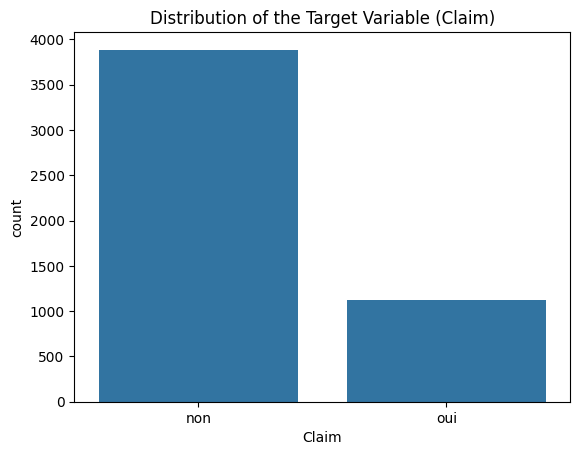

In [6]:
sns.countplot(x='Claim', data=df_train)
plt.title("Distribution of the Target Variable (Claim)")
plt.show()

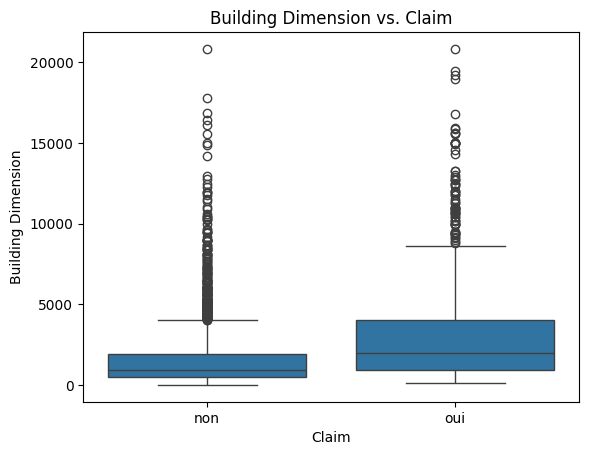

In [7]:
sns.boxplot(x='Claim', y='Building Dimension', data=df_train)
plt.title("Building Dimension vs. Claim")
plt.show()